# Testing Microbiome Model

## imports

In [75]:
import numpy as np
import matplotlib.pyplot as plt

eps = 10e-8

## Functions and definitions for cells/grids

In [52]:
class cell:
    def __init__(self, x, y):
        self.x = x ## x coordinate of grid cell
        self.y = y ## y coordinate of grid cell
        self.contents = None ## pointer to agent in cell
        self.concentration = 0.0 ## the concentration of antibiotic resistance in the grid cell
        self.neighbors = [] ## the list of neighbors to this grid cell

## Functions and definitions for agents

In [229]:
class agent:
    def __init__(self):
        self.genotype = {"mu_0":0.0} ## the dictionary holding important genotypic values
        self.health = 1.0 ## health pool for the agent
        self.resistance = 0.0 ## resistance of the agent to antibacterial
        self.x = 0 ## x coordinate of the agent
        self.y = 0 ## y coordinate of the agent
        self.neighbors = [] ## list of neighbors to this agent
        self.currentCell = None ## the cell this agent currently lives on
    
    def __hash__(self):
        return hash(str(self.x) + "," + str(self.y))
    
    def __eq__(self, other):
        if(hash(self) == hash(other)):
            return True
        return False
    
    ### randomize the genes
    def randomizeGenes(self):
        self.genotype["mu_0"] = np.random.random()
        ## initial draw for resistance
        self.resistance = np.random.normal(loc = self.genotype["mu_0"])
    
    ## place the agent on a cell c
    def place(self, c):
        self.x = c.x
        self.y = c.y
        self.currentCell = c
        c.contents = self
        
    ## The update function updates the agent every iteration
    def update(self, 
               bGrowthRate, 
               nextAgentList, 
               agentsToDie,
               dmgRate):
            
        ## Take Damage
        self.damage(dmgRate)
        ## die if health too low
        if(self.health < eps):
            agentsToDie.append(self)
            return
        
        ## degrade concentration
        self.degrade()
        
        ## Try to grow
        offspring = self.grow(bGrowthRate)
        if(offspring != None):
            nextAgentList.append(offspring)
    
    ## Take damage due to antibacterial in the environment
    def damage(self, dmgRate):
        self.health *= (1.0 - self.currentCell.concentration)
        
    ## degrade the concentration of antibacterial at this location
    def degrade(self):
        if(self.currentCell.concentration > eps 
           and self.resistance >= eps):
            self.currentCell.concentration -= self.resistance
        elif(self.currentCell.concentration <= eps):
            self.currentCell.concentration = 0.0
    
    ## attempt to grow according to the basal growth rate
    def grow(self, bGrowthRate):
        roll = np.random.random()
        if(roll < bGrowthRate):
            emptyNeighborCells = []
            for c in self.currentCell.neighbors:
                if(c.contents == None):
                    emptyNeighborCells.append(c)
            if(len(emptyNeighborCells) == 0):
                return None
            np.random.shuffle(emptyNeighborCells)
            offspring = agent()
            offspring.place(emptyNeighborCells[0])
            offspring.genotype = self.genotype
            offspring.resistance = np.random.normal(loc = offspring.genotype["mu_0"])
        else:
            return None
        return offspring
                    

## Simulation

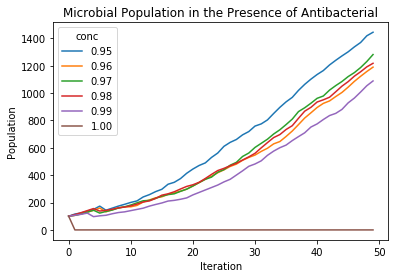

In [235]:
### Sim setup, global parameters
initPopSize = 100
gridWidth = 50
gridHeight = 50
numIters = 50
bGrowthRate = 0.1 # basal growth rate
dmgRate = 0.1
                    
concRange = np.arange(0.95,1.00,0.01)

## try different concentrations
plt.figure()
for i in range(len(concRange)):
    ### statistic variables
    pop = [] ### track pop size over time
    births = [] ### track births over time
    deaths = [] ### track deaths over time
    avgRes = []
    totalConc=[]
    
    runSim(concRange[i], 
           pop, 
           births, 
           deaths, 
           dmgRate,
           avgRes,
          totalConc)
    plt.plot(pop, label="{:.2f}".format(concRange[i]))
plt.xlabel("Iteration")
plt.ylabel("Population")
plt.legend(title="conc")
plt.title("Microbial Population in the Presence of Antibacterial")
plt.show()

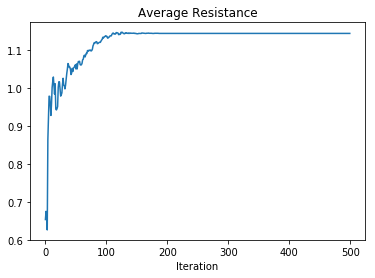

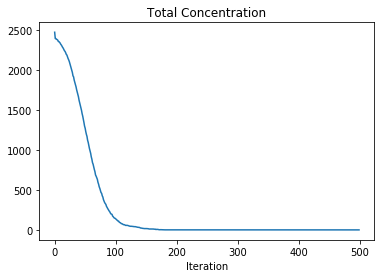

In [236]:
## Evaluate evolution of resistance
### statistic variables
pop = [] ### track pop size over time
births = [] ### track births over time
deaths = [] ### track deaths over time
avgRes = [] ### track average resistance over time
totalConc = [] ### track total concentraion over time
numIters = 500
bGrowthRate = 0.1
runSim(0.99, pop, births, deaths, dmgRate, avgRes, totalConc)
plt.figure()
plt.plot(avgRes)
plt.title("Average Resistance")
plt.xlabel("Iteration")
plt.show()

plt.figure()
plt.plot(totalConc)
plt.title("Total Concentration")
plt.xlabel("Iteration")
plt.show()

In [216]:
## function to run the sim 
def runSim(flatConc, 
           pop, 
           births, 
           deaths, 
           dmgRate,
           avgRes,
           totalConc):
    
    ### create grid
    grid = []
    for i in range(gridWidth):
        grid.append([])
        for j in range(gridHeight):
            grid[i].append(cell(i,j))
            grid[i][j].concentration = flatConc
    ### Assign neighbors to grid cells
    for i in range(gridWidth):
        for j in range(gridWidth):
            for ii in range(-1,2):
                for jj in range(-1,2):
                    dx = i + ii
                    dy = j + jj
                    if(dx >= 0 and 
                       dx < gridWidth and 
                       dy >= 0 and 
                       dy < gridHeight and
                      ii != 0 and jj != 0):
                        grid[i][j].neighbors.append(grid[dx][dy])
                    
    ### Create initial population
    agentList = []
    for i in range(initPopSize):
        a = agent()
        a.randomizeGenes()
        rx = np.random.randint(0, gridWidth)
        ry = np.random.randint(0, gridHeight)
        while(grid[rx][ry].contents != None):
            rx = np.random.randint(0, gridWidth)
            ry = np.random.randint(0, gridHeight)
        a.place(grid[rx][ry])
        a.randomizeGenes()
        agentList.append(a)

    ### Run Sim
    for i in range(numIters):
        
        concSum = 0.0
        for x in range(gridWidth):
            for y in range(gridHeight):
                concSum += grid[x][y].concentration
        totalConc.append(concSum)
        
        resSum = 0.0
        pop.append(len(agentList))
        nextAgentList = [] ### for next iteration population
        agentsToDie = [] ### Agents to remove for next iteration
        np.random.shuffle(agentList)
        for j in range(len(agentList)):
            resSum += agentList[j].resistance
            agentList[j].update(bGrowthRate, 
                                nextAgentList, 
                                agentsToDie,
                                dmgRate)
        births.append(len(nextAgentList))
        deaths.append(len(agentsToDie))

        for j in range(len(agentList)):
            nextAgentList.append(agentList[j])

        agentList = nextAgentList    

        ## remove dead agents
        toDie = set(agentsToDie)
        temp = []
        for a in agentList:
            if a in toDie:
                a.currentCell.contents = None
            else:
                temp.append(a)
        agentList = temp
        
        if(pop[-1] > 0):
            avgRes.append(resSum/float((pop[-1])))
        else:
            avgRes.append(0.0)

# TO DO:

1. Mutation
2. Add std deviation to genotype
3. Check min, max resistance
4. Check Genotypic diversity
5. Add degredation of neighbor cells
6. Add variable antibacterial